![](http://wiki.swarma.net/images/e/e7/集智AI学园首页左上角logo_2017.8.17.png)

# 火炬上的深度学习（下）第二节：机器也懂感情？

## 课后练习：使用 LSTM 来判断人名属于哪个国家

我们要使用 PyTorch 搭建一个 LSTM 模型。

模型的输入是用ASCII字符表示的姓氏，输出是模型对这个姓氏所属语言的判断。

模型的训练数据是来自18种语言的2万条左右的姓氏文本。

训练完毕的理想模型可以预测出一个姓氏是属于哪种语言的。并且，我们还可以通过模型的预测结果分析各语言姓氏的相似性。

最终训练好的模型可以像下面那样使用。

```python
predict Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

## 理解 LSTM

看到本练习相信你已经对 LSTM 有一定的认识了。

如果还不熟悉 LSTM 可以再去看一下张老师讲的[课程](http://campus.swarma.org/gcou=10341)

## 处理训练数据

在提供的数据文件中，包含在 data/names 目录下的是18个命名规则为"[Language].txt"的文本文件，每个文件都包含一些名字，每个名字占一行。

In [1]:
import glob

all_filenames = glob.glob('./data/names/*.txt')
print(all_filenames)

['./data/names\\Arabic.txt', './data/names\\Chinese.txt', './data/names\\Czech.txt', './data/names\\Dutch.txt', './data/names\\English.txt', './data/names\\French.txt', './data/names\\German.txt', './data/names\\Greek.txt', './data/names\\Irish.txt', './data/names\\Italian.txt', './data/names\\Japanese.txt', './data/names\\Korean.txt', './data/names\\Polish.txt', './data/names\\Portuguese.txt', './data/names\\Russian.txt', './data/names\\Scottish.txt', './data/names\\Spanish.txt', './data/names\\Vietnamese.txt']


现在先让我们解决这个问题：

在我们收集的18种语言的名字中，中文、日文、韩文等名字都已经转化为音译的字母。这样做是因为有些语言的名字并不能用普通的ASCII英文字符来表示，比如“Ślusàrski”，这些不一样的字母会增加神经网络的“困惑”，影响其训练效果。所以我们得首先把这些特别的字母转换成普通的ASCII字符（即26个英文字母）。

In [2]:
import unicodedata
import string

# 使用26个英文字母大小写再加上.,;这三个字符
# 建立字母表，并取其长度
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# 将Unicode字符串转换为纯ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))
print('all_letters:', all_letters)
print('all_letters:', len(all_letters))

Slusarski
all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
all_letters: 57


然后再建立 readLines 方法，用于从文件中一行一行的将姓氏读取出来。

以18种语言为索引，将读取出的姓氏各自存储在名为 `category_lines` 的字典中。

In [3]:
import os.path

# 构建category_lines字典，名字和每种语言对应的列表
category_lines = {}
all_categories = []

# 按行读取出名字并转换成纯ASCII
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    # 取出每个文件的文件名（语言名）
    #category = filename.split('/')[-1].split('.')[0]
    category = os.path.splitext(os.path.split(filename)[-1])[0]
    # 将语言名加入到all_categories列表
    all_categories.append(category)
    # 取出所有的姓氏lines
    lines = readLines(filename)
    # 将所有姓氏以语言为索引，加入到字典中
    category_lines[category] = lines

n_categories = len(all_categories)

print('all_categories:', all_categories)
print('n_categories =', n_categories)

all_categories: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
n_categories = 18


`all_categories` 中包含18种语言的姓氏。

`category_lines` 中以18种语言为索引，存储了所有的姓氏。

In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


我们来统计下数据中所有姓氏的个数。

In [5]:
all_line_num = 0
for key in category_lines:
    all_line_num += len(category_lines[key])
print(all_line_num)

20074


## 准备训练

In [6]:
# 首先导入程序所需要的程序包

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable


#绘图、计算用的程序包
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

%matplotlib inline

下面我们再编写一个方法用于快速地获得一个训练实例（即一个名字以及它所属的语言）：

其中 line_index 中保存的是选择的姓氏中的字母的索引，这个需要你去实现。

In [7]:
import random

def random_training_pair():   
    # 随机选择一种语言
    category = random.choice(all_categories)
    # 从语言中随机选择一个姓氏
    line = random.choice(category_lines[category])
    # 我们将姓氏和语言都转化为索引
    category_index = all_categories.index(category)
    
    line_index = []
    # 你需要把 line 中字母的索引加入到line_index 中
    # Todo:
    for c in line:
        #line_index.append(ord(c)-ord('A'))
        line_index.append(all_letters.find(c))
    
    
    return category, line, category_index, line_index

# 测试一下上面的函数方法
for i in range(5):
    category, line, category_index, line_index = random_training_pair()
    print('category =', category, '/ line =', line)
    print('category =', category_index, '/ line =', line_index)

category = Irish / line = O'Bree
category = 8 / line = [40, 56, 27, 17, 4, 4]
category = Japanese / line = Okuma
category = 10 / line = [40, 10, 20, 12, 0]
category = Czech / line = Nadwornik
category = 2 / line = [39, 0, 3, 22, 14, 17, 13, 8, 10]
category = Dutch / line = Kikkert
category = 3 / line = [36, 8, 10, 10, 4, 17, 19]
category = Greek / line = Glynatsis
category = 7 / line = [32, 11, 24, 13, 0, 19, 18, 8, 18]


我们再建立一个用户转化模型输出的辅助函数。

它可以把网络的输出（1 x 18的张量）转化成“最可能的语言类别”，这就需要找到18列数据中哪个概率值最大。

我们可以使用 `Tensor.topk` 方法来得到数据中最大值位置的索引。

In [9]:
def category_from_output(output):
    # 1 代表在‘列’间找到最大
    # top_n 是具体的值
    # top_i 是位置索引
    # 注意这里 top_n 和 top_i 都是1x1的张量
    # output.data 取出张量数据
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    # 从张量中取出索引值
    category_i = top_i[0][0]
    # 返回语言类别名和位置索引
    return all_categories[category_i], category_i

## 编写 LSTM 模型

现在是建立 LSTM 模型的时候了。

我在模型中设置了一些空缺，**你需要编写空缺处的代码。**

如果遇到问题，可以参考[课程](http://campus.swarma.org/gcou=10341)中的代码讲解哦！

In [14]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size

        # LSTM的构造如下：
        # 一个embedding层，将输入的任意一个单词（list）映射为一个向量（向量的维度与隐含层有关系？）
        # 没有关系，embedding使输出向量与隐含层维度相同只是由于想让序列中的每个元素有一个对应的隐含状态值。
        # 但是这只是人类的想法，事实上机器并不一定这样处理就最好。
        self.embedding = nn.Embedding(input_size, embedding_size)
        # 然后是一个LSTM隐含层，共有hidden_size个LSTM神经元，并且它可以根据n_layers设置层数
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers)
        # 接着是一个全链接层，外接一个softmax输出
        self.fc = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, input, hidden=None):
        #首先根据输入input，进行词向量嵌入
        embedded = self.embedding(input)
        
        # 这里需要注意！
        # PyTorch设计的LSTM层有一个特别别扭的地方是，输入张量的第一个维度需要是时间步，
        # 第二个维度才是batch_size，所以需要对embedded变形
        # 因为此次没有采用batch，所以batch_size为1
        # 变形的维度应该是（input_list_size, batch_size, hidden_size）
        embedded = embedded.view(input.data.size()[0], 1, self.embedding_size)
    
        # 调用PyTorch自带的LSTM层函数，注意有两个输入，一个是输入层的输入，另一个是隐含层自身的输入
        # 输出output是所有步的隐含神经元的输出结果，hidden是隐含层在最后一个时间步的状态。
        # 注意hidden是一个tuple，包含了最后时间步的隐含层神经元的输出，以及每一个隐含层神经元的cell的状态
        
        output, hidden = self.lstm(embedded, hidden)
        
        #我们要把最后一个时间步的隐含神经元输出结果拿出来，送给全连接层
        output = output[-1,...]

        #全链接层
        out = self.fc(output)
        # softmax
        out = self.logsoftmax(out)
        return out

    def initHidden(self):
        # 对隐单元的初始化
        # 对引单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        # 对隐单元内部的状态cell的初始化，全0
        cell = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        return (hidden, cell)



## 训练网络

每次训练模型的时候，我的心里都是有点小激动的！

我同样在训练程序中预留了一些空位，**你要编写空余位置的程序**，训练才可以正常进行。

In [24]:
import time
import math

# 开始训练LSTM网络

# 构造一个LSTM网络的实例
#lstm = LSTMNetwork(n_letters, 10, n_categories, 2)
lstm = LSTMNetwork(n_letters, 10, 20, n_categories, 2)
#lstm = torch.load('homework_5hiden_10epoch_1.49.mdl')

#定义损失函数
cost = torch.nn.NLLLoss()

#定义优化器,
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)
records = []

# 用于计算训练时间的函数
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

# 开始训练，一共5个epoch，否则容易过拟合
losses = []
n_epochs = 30
for epoch in range(n_epochs):
    #每次随机选择数据进行训练，每个 EPOCH 训练“所有名字个数”次。
    for i in range(all_line_num):
        category, line, y, x = random_training_pair()
        x = Variable(torch.LongTensor(x))
        y = Variable(torch.LongTensor([y]))
        optimizer.zero_grad()
        
        # Step1:初始化LSTM隐含层单元的状态
        hidden = lstm.initHidden()
        
        # Step2:让LSTM开始做运算，注意，不需要手工编写对时间步的循环，而是直接交给PyTorch的LSTM层。
        # 它自动会根据数据的维度计算若干时间步
        output = lstm(x, hidden)
        
        # Step3:计算损失
        loss = cost(output, y)
        losses.append(loss.data.numpy()[0])
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #每隔3000步，跑一次校验集，并打印结果
        if 0 != i and i % 3000 == 0:
            # 判断模型的预测是否正确
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            # 计算训练进度
            training_process = (all_line_num * epoch + i) / (all_line_num * n_epochs) * 100
            training_process = '%.2f' % training_process
            print('第{}轮，训练损失：{:.2f}，训练进度：{}%，（{}），名字：{}，预测国家：{}，正确？{}'\
                .format(epoch, np.mean(losses), float(training_process), time_since(start), line, guess, correct))
            records.append([np.mean(losses)])
            losses = []
torch.save(lstm,'homework.mdl')

第0轮，训练损失：2.53，训练进度：0.5%，（0m 22s），名字：Rosario，预测国家：Italian，正确？✗ (Portuguese)
第0轮，训练损失：2.03，训练进度：1.0%，（0m 45s），名字：Assaf，预测国家：Arabic，正确？✓
第0轮，训练损失：1.85，训练进度：1.49%，（1m 7s），名字：Manoukarakis，预测国家：Greek，正确？✓
第0轮，训练损失：1.71，训练进度：1.99%，（1m 29s），名字：Zabek，预测国家：Polish，正确？✓
第0轮，训练损失：1.62，训练进度：2.49%，（1m 52s），名字：Joubert，预测国家：Dutch，正确？✗ (French)
第0轮，训练损失：1.55，训练进度：2.99%，（2m 17s），名字：Emerick，预测国家：Polish，正确？✗ (English)
第1轮，训练损失：1.47，训练进度：3.83%，（3m 1s），名字：Hyun ，预测国家：Korean，正确？✓
第1轮，训练损失：1.37，训练进度：4.33%，（3m 27s），名字：Shaitanov，预测国家：Russian，正确？✓
第1轮，训练损失：1.30，训练进度：4.83%，（3m 52s），名字：Maehata，预测国家：Japanese，正确？✓
第1轮，训练损失：1.30，训练进度：5.33%，（4m 18s），名字：Blober，预测国家：Dutch，正确？✗ (Czech)
第1轮，训练损失：1.22，训练进度：5.82%，（4m 44s），名字：Bei，预测国家：Vietnamese，正确？✗ (Chinese)
第1轮，训练损失：1.17，训练进度：6.32%，（5m 9s），名字：Germano，预测国家：Italian，正确？✓
第2轮，训练损失：1.16，训练进度：7.16%，（5m 52s），名字：Meier，预测国家：German，正确？✓
第2轮，训练损失：1.10，训练进度：7.66%，（6m 15s），名字：Rios，预测国家：Portuguese，正确？✗ (Spanish)
第2轮，训练损失：1.08，训练进度：8.16%，（6m 37s），名字：Zhuan，预测国家：Arabic，正确？✗ (Chinese)
第2轮，训练

第20轮，训练损失：0.45，训练进度：69.66%，（57m 21s），名字：Ko，预测国家：Korean，正确？✓
第21轮，训练损失：0.47，训练进度：70.5%，（58m 0s），名字：Lawniczak，预测国家：Polish，正确？✓
第21轮，训练损失：0.46，训练进度：71.0%，（58m 25s），名字：Totah，预测国家：Arabic，正确？✓
第21轮，训练损失：0.47，训练进度：71.49%，（58m 52s），名字：Kaiser，预测国家：German，正确？✓
第21轮，训练损失：0.45，训练进度：71.99%，（59m 17s），名字：Miksatkova，预测国家：Czech，正确？✓
第21轮，训练损失：0.44，训练进度：72.49%，（59m 41s），名字：Madeira，预测国家：Portuguese，正确？✓
第21轮，训练损失：0.43，训练进度：72.99%，（60m 5s），名字：Yuan，预测国家：Chinese，正确？✓
第22轮，训练损失：0.43，训练进度：73.83%，（60m 45s），名字：Tze，预测国家：Chinese，正确？✓
第22轮，训练损失：0.42，训练进度：74.33%，（61m 9s），名字：Warszawski，预测国家：Polish，正确？✓
第22轮，训练损失：0.45，训练进度：74.83%，（61m 33s），名字：Sutherland，预测国家：Scottish，正确？✓
第22轮，训练损失：0.46，训练进度：75.33%，（61m 57s），名字：Rigatos，预测国家：Greek，正确？✓
第22轮，训练损失：0.48，训练进度：75.82%，（62m 21s），名字：Koumanidis，预测国家：Greek，正确？✓
第22轮，训练损失：0.42，训练进度：76.32%，（62m 44s），名字：Said，预测国家：Arabic，正确？✓
第23轮，训练损失：0.44，训练进度：77.16%，（63m 24s），名字：Trampota，预测国家：Czech，正确？✓
第23轮，训练损失：0.45，训练进度：77.66%，（63m 47s），名字：Hadash，预测国家：Russian，正确？✗ (Czech)
第23轮，训练损失：0.43，训练进度：7

C:\ProgramData\Anaconda3\envs\tf36\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type LSTMNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


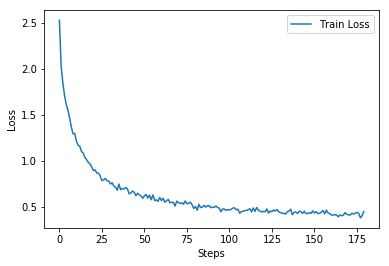

In [26]:
a = [i[0] for i in records]
plt.plot(a, label = 'Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

## 通过姓氏分析语言的相似性

激动人心的时刻到了！

下面将使用10000条数据评估训练好的模型，并根据评估的结果绘制图形，从图形中我们可以发现哪些语言的姓氏是相似的！

**你需要自行编写 evaluate 函数的内容。**

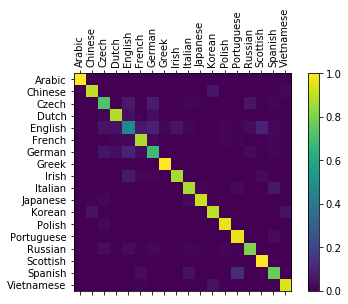

In [27]:
import matplotlib.pyplot as plt


# 建立一个（18 x 18）的方阵张量
# 用于保存神经网络做出的预测结果
confusion = torch.zeros(n_categories, n_categories)
# 用于评估的模型的测试次数
n_confusion = 10000


# 评估用方法 传进去一个名字，给出预测结果
# 可以观察到这个方法的实现与 train 方法前半部分类似
# 其实它就是去掉反向传播的 train 方法
def evaluate(line_list):
    # 调用模型前应该先初始化模型的隐含层
    hidden = lstm.initHidden()
    # 别忘了将输入的list转化为torch.Variable
    line_variable = Variable(torch.LongTensor(line_list))
    # 调用模型
    output = lstm(line_variable, hidden)
    
    return output

# 循环一万次
for i in range(n_confusion):
    # 随机选择测试数据，包括姓氏以及所属语言
    category, line, category_index, line_list = random_training_pair()
    # 取得预测结果
    output = evaluate(line_list)
    
    # 取得预测结果的语言和索引
    guess, guess_i = category_from_output(output)
    
    # 以姓氏实际的所属语言为行
    # 以模型预测的所属语言为列
    # 在方阵的特定位置增加1

    confusion[category_index][guess_i] += 1

# 数据归一化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 设置一个图表
fig = plt.figure()
ax = fig.add_subplot(111)
# 将 confusion 方阵数据传入
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 设置图表两边的语言类别名称
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

先看行再看列，行标签代表姓氏实际所属语言，列标签代表模型预测姓氏所属语言。

色块颜色越亮代表预测次数越高。整张图表中对角线最亮，说明模型对大部分数据的预测都是准确的。

但是！我们要观察的是预测错误的情况，即对角线以外的亮色块！

先看 English 这一行，可以看到 English 对角线上的色块很暗啊，说明模型对英文姓氏的预测很差。同时，除对角线方块外，在 English 这一行可以观察到很多浅色方块，它们分别是：Czech（捷克语）、French（法语）、German（德语）、Irish（爱尔兰语）、Scottish（苏格兰语）。这些国家文化相近，姓氏相似，所以模型没能做到非常好的区分。

而东方国家，让我们观察中国这一行，可以看到中国、韩国、越南（Vietnamese）的姓氏有一定的相似度，这与国家间的文化是相符的。

另外还有西班牙和葡萄牙，这两个国家的姓氏也有些相似。

## 将模型封装的更易用

我们重新把焦点转移到训练的模型上来。

下面我要编写一个函数将训练的模型封装起来，以便于调用。

In [28]:
# predict函数
# 第一个参数为要进行预测的姓氏
# 第二个参数为预测最大可能所属语言的数量
def predict(input_line, n_predictions=3):
    # 首先将用户输入的名字打印出来
    print('\n> %s' % input_line)
    # 将用户输入的字符串转化为索引列表
    input_line = list(map(lambda x: all_letters.find(x), input_line))
    # 将用户输入的名字传入模型中进行预测
    output = evaluate(input_line)

    # 获得概率最大的n_predictions个语言类别
    topv, topi = output.data.topk(n_predictions, 1, True)
    # topv中保存着概率值
    # topi中保存着位置索引

    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        # 将预测概率最大的三种语言类别格式化后打印出来
        print('(%.2f) %s' % (value, all_categories[category_index]))
        # 将它们存储到 predictions 中
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Han')
predict('Zhang')
predict('Ma')


> Dovesky
(-0.31) Russian
(-1.40) Czech
(-4.17) English

> Jackson
(-0.01) Scottish
(-4.59) English
(-7.08) Irish

> Satoshi
(-0.00) Japanese
(-9.06) Russian
(-9.41) Italian

> Han
(-0.93) Korean
(-1.08) Vietnamese
(-1.39) Chinese

> Zhang
(-0.20) Chinese
(-1.84) Vietnamese
(-4.10) Korean

> Ma
(-0.30) Korean
(-1.57) Vietnamese
(-3.90) Polish


In [ ]:
第一次训练
看来我Mr Zhang还是纯正的中国人~
原来我媳妇Mrs Ma是个韩国人~早知道她以前在韩国公司上班还认识一堆韩国人，原来就是韩国人啊~怪不得她不喜欢看韩剧都看腻了才来中国的吧~话说韩国妹子都爱整容她不会也整过吧~怪不得和身份证上的样子不像呢~可是身份证上写的和我是同乡啊，办的假证吧~为了我她还真是拼命了呢HEHEHEHE~那她的一堆中国亲属又是怎么回事呢？都是被她收买的吧~#…*！…#￥#@&%*省略一万字中二病已经无法阻挡了
不知道上面这段鬼话用NLP处理一下能生成什么呢？

In [ ]:
第二次训练
epoch = 5 loss = 1.54
参数相同
> Ma
(-0.51) Vietnamese
(-1.36) Chinese
(-2.24) Korean
我媳妇Mrs Ma又变成了越南人！这也太不靠谱了吧~不记得从越南买过媳妇啊~严重怀疑这个LSTM模型的能力了。。。看来还需要改进啊！训练时间长一点会不会好呢？

In [ ]:
第三次训练
epoch = 10 loss = 1.35
> Zhang
(-0.70) Korean
(-0.95) Chinese
(-2.42) Vietnamese

> Ma
(-0.86) Chinese
(-1.21) Vietnamese
(-1.29) Korean
我媳妇Mrs Ma倒是中国人了，可是我Mr Zhang却变成了韩国人~捂脸

In [ ]:
第四次训练
epoch = 20，使用保存的模型加载后继续训练，初始loss = 0.96，结束loss = 0.95
> Zhang
(-0.21) Chinese
(-2.69) Korean
(-3.46) Vietnamese

> Ma
(-0.72) Vietnamese
(-1.35) Chinese
(-1.38) Korean
我恢复了中国人身份，媳妇又成了越南人。话说这次的loss曲线为什么初始值与上次不一致？又为什么先升后降？
检查数据发现Ma这个姓在汉语、韩语和越南语中都有，所以会这么纠结。
但是Zhang这个姓韩语和越南语中并没有，为什么训练3中会判为韩国人呢？

In [ ]:
训练5
epoch = 30，加载模型，初始loss = 0.44, 结束loss = 0.87
> Zhang
(-0.09) Chinese
(-2.94) Korean
(-4.52) English

> Ma
(-0.65) Vietnamese
(-0.97) Korean
(-2.30) Chinese
明白了，曲线先升后降是因为第一次的mean loss只包含了第一次predict的loss，所以不具代表性。而且,losses值应该在每次产生曲线值后清空，一直累加是不对的
多语种同姓的问题怎么解决呢？

In [ ]:
embedding层的输出维度和隐含层维度没有关系，embedding使输出向量与隐含层维度相同只是由于想让序列中的每个元素有一个对应的隐含状态值。
但是这只是人类的想法，事实上机器并不一定这样处理就最好。
那么, 是不是增加隐含层节点数量可以改善性能呢？

In [ ]:
训练6
先减少隐含节点，这必然能提高训练效率，要看的是能否达到相同的loss。
epoch = 10，hiden = 5，初始loss = 2.84, 结束loss = 1.49
> Zhang
(-0.50) Korean
(-1.05) Chinese
(-3.85) Vietnamese

> Ma
(-0.68) Vietnamese
(-1.03) Chinese
(-2.12) Korean
 loss = 1.49略高于10个隐含单元时的1.35，矩阵图上看明显没有10个隐含单元时好。

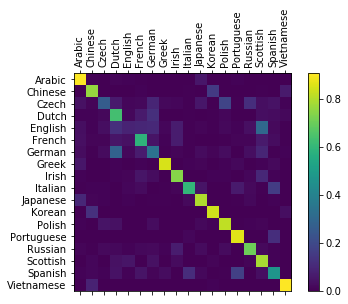
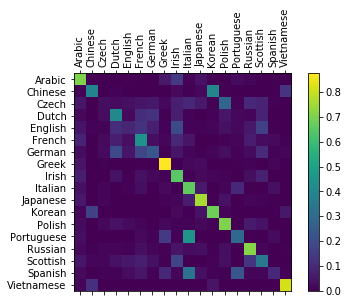


In [ ]:
训练7
epoch = 30，hiden = 5，初始loss = 2.83, 结束loss = 1.42
> Zhang
(-0.63) Chinese
(-1.10) Korean
(-3.18) Irish

> Ma
(-0.79) Korean
(-1.04) Chinese
(-1.74) Vietnamese
 loss = 1.49远远高于10个隐含单元时的0.87，矩阵图同样没有10个隐含单元时好。这说明5个隐含节点可能已经不足以记忆任务所需的复杂模式。

In [ ]:
训练8
epoch = 30，hiden = 20，初始loss = 2.53, 结束loss = 0.45
> Zhang
(-0.20) Chinese
(-1.84) Vietnamese
(-4.10) Korean

> Ma
(-0.30) Korean
(-1.57) Vietnamese
(-3.90) Polish
loss = 0.45远远低于10个隐含单元时的0.87，矩阵图明显较好。不知道有没有过拟合。

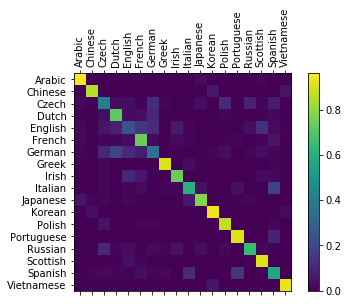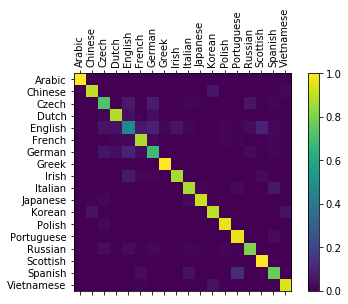

到这里本次练习就结束了，希望本次练习可以加深你对 LSTM 的认识。如果在练习中遇到了问题，可以在 火炬上的深度学习 课程讨论群 中进行提问，对不模型有不明白的地方，可以再重复学习下课程视频中的讲解。

![](http://wiki.swarma.net/images/c/ca/AI学园.jpg)